German Traffic Sign Recognition Benchmark GTSRB
===============================================
---
pjluc 2019 - CNRS/DEVLOG - Formation Deep Learning

## 1/ About the dataset
Name : [German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb)  
Available [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html) 
or on **[kaggle](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)**  
A nice example from : [Alex Staravoitau](https://navoshta.com/traffic-signs-classification/)  

In few words :
 - Images : Variable dimensions, rgb
 - Train set : 39209 images  
 - Test set : 12630 images
 - Classes : 0 to 42

## 2/ Import and start

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from sklearn.utils import shuffle
from skimage.morphology import disk
from skimage.filters import rank
from skimage import exposure
import csv
import os
import math, random
import time, sys
import PIL
from PIL import Image, ImageDraw, ImageOps


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


## 3/ Read the dataset
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
 - Each directory contains one CSV file with annotations ("GT-<ClassID>.csv") and the training images
 - First line is fieldnames: Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId  
    
### 3.1/ Usefull functions

In [2]:
def update_progress(what,i,imax):
    bar_length = 40
    if (i%int(imax/bar_length))!=0 and i<imax:
        return
    progress  = float(i/imax)
    block     = int(round(bar_length * progress))
    endofline = '\r' if progress<1 else '\n'
    text = "{:16s} [{}] {:.1f}%".format( what, "#"*block+"-"*(bar_length-block), progress*100)
    print(text, end=endofline)


def read_dataset_dir(csv_filename, nlines):
    '''Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.

    Arguments:  csv filename
                Example /data/GTSRB/Train.csv
    Returns:   list of images, list of corresponding labels'''

    # ---- csv filename and path
#     print("Read csv file : {:>16s}  ".format(os.path.basename(csv_filename)))#, end='')
    name=os.path.basename(csv_filename)
    path=os.path.dirname(csv_filename)
    # ---- Read it
    (i,x,y) = (0,[],[])
    with open(csv_filename) as csv_file:
        reader = csv.DictReader(csv_file, delimiter=',')
        for row in reader:
            image   = Image.open( path+'/'+row['Path'] )
            image.load()
            classId = int(row['ClassId'])
            x.append(image)
            y.append(classId)
            i+=1
            update_progress(name,i,nlines)
        csv_file.close()
    # ---- Return
    return x,y

def plot_images(x,y, indices, columns=12, x_size=1, y_size=1, colorbar=False, y_pred=None,save_as=None, cm='binary'):
    """
    Show some images in a grid, with legends
    args:
        X: images
        y: real classes
        indices: indices of images to show
        columns: number of columns (12)
        x_size,y_size: figure size
        colorbar: show colorbar (False)
        y_pred: predicted classes (None)
        cm: Matplotlib olor map
    returns: 
        nothing
    """
    rows    = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+0.35)))
    n=1
    errors=0 
    if np.any(y_pred)==None:
        y_pred=y
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        img=axs.imshow(x[i],cmap = cm, interpolation='lanczos')
#         img=axs.imshow(x[i],cmap = cm)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.set_yticks([])
        axs.set_xticks([])
        if y[i]!=y_pred[i]:
            axs.set_xlabel('{} ({})'.format(y_pred[i],y[i]))
            axs.xaxis.label.set_color('red')
            errors+=1
        else:
            axs.set_xlabel(y[i])
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    plt.show()

### 3.2 Read the data

In [3]:
%%time

# ---- Read datasets
(x_train,y_train) = read_dataset_dir('./data/GTSRB/Train.csv',39209)
(x_test ,y_test)  = read_dataset_dir('./data/GTSRB/Test.csv',12630)
(x_meta ,y_meta)  = read_dataset_dir('./data/GTSRB/Meta.csv',43)
    
# ---- Shuffle train set
combined = list(zip(x_train,y_train))
random.shuffle(combined)
x_train,y_train = zip(*combined)

# ---- Sort Meta
combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

Train.csv        [########################################] 100.0%
Test.csv         [########################################] 100.0%
Meta.csv         [########################################] 100.0%
CPU times: user 10.1 s, sys: 11.2 s, total: 21.3 s
Wall time: 39.8 s


## 4/ Few statistics about train dataset
### 4.1 Do statistics 

In [4]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly) = image.size
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly) = image.size
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

### 4.2 Show it

x_train size :  39209
y_train size :  39209
x_test size  :  12630
y_test size  :  12630


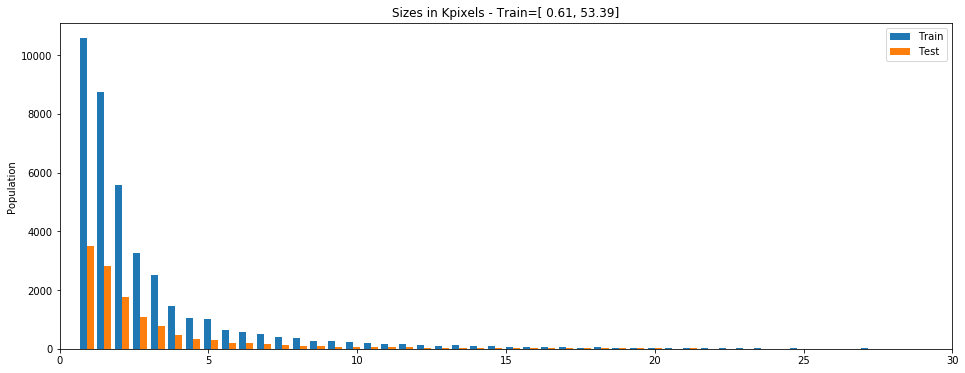

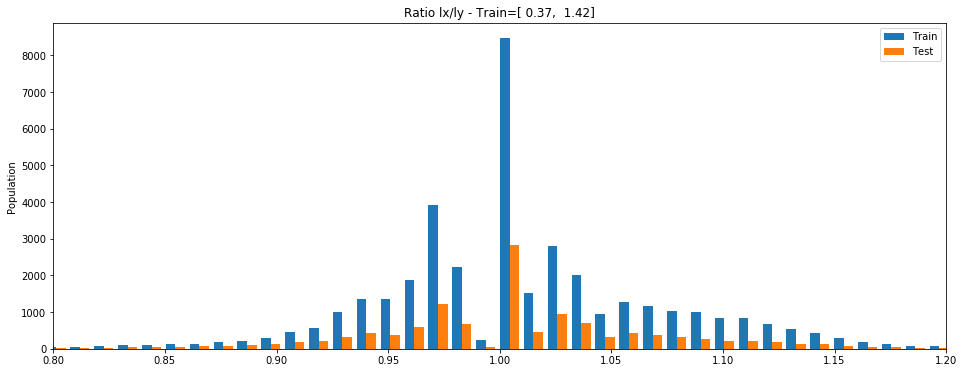

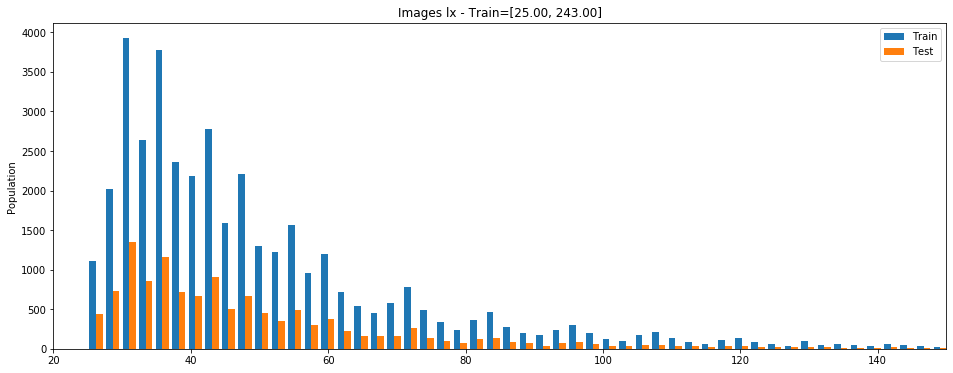

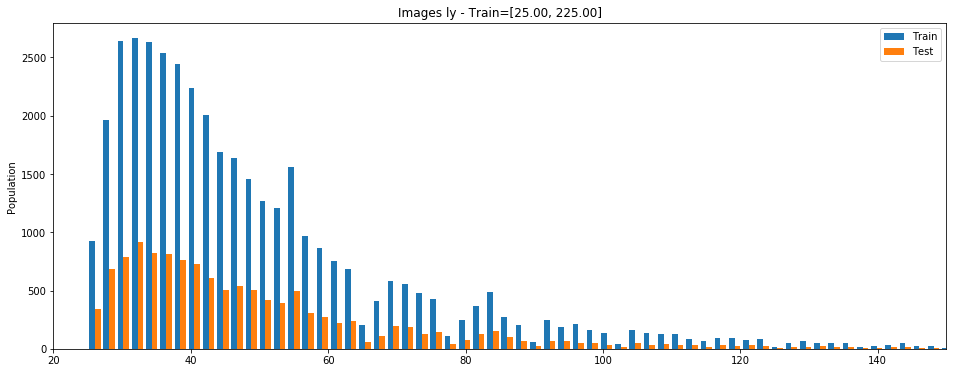

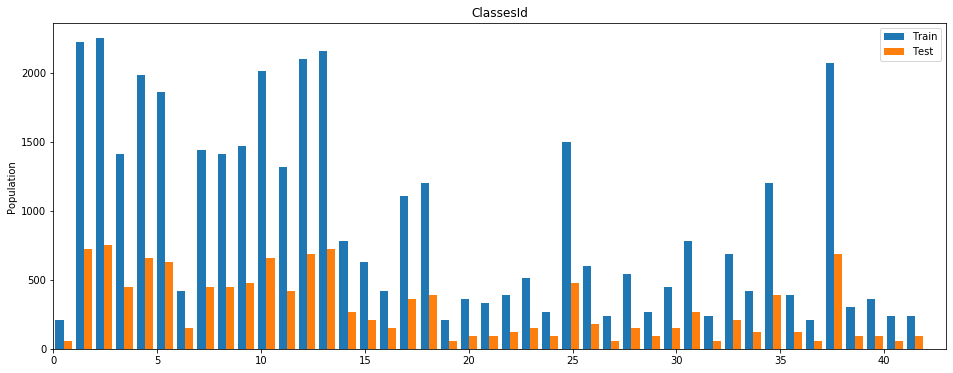

In [5]:
# ------ Global stuff
print("x_train size : ",len(x_train))
print("y_train size : ",len(y_train))
print("x_test size  : ",len(x_test))
print("y_test size  : ",len(y_test))

# ------ Statistics / sizes
plt.figure(figsize=(16,6))
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title='Sizes in Kpixels - Train=[{:5.2f}, {:5.2f}]'.format(min(train_size),max(train_size)), 
              ylabel='Population',
              xlim=[0,30])
plt.legend(['Train','Test'])
plt.show()
# ------ Statistics / ratio lx/ly
plt.figure(figsize=(16,6))
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)), 
              ylabel='Population',
              xlim=[0.8,1.2])
plt.legend(['Train','Test'])
plt.show()
# ------ Statistics / lx
plt.figure(figsize=(16,6))
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)), 
              ylabel='Population',
              xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()
# ------ Statistics / ly
plt.figure(figsize=(16,6))
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)), 
              ylabel='Population',
              xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()
# ------ Statistics / classId
plt.figure(figsize=(16,6))
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='ClassesId', 
              ylabel='Population',
              xlim=[0,43])
plt.legend(['Train','Test'])
plt.show()

## 5/ List of classes

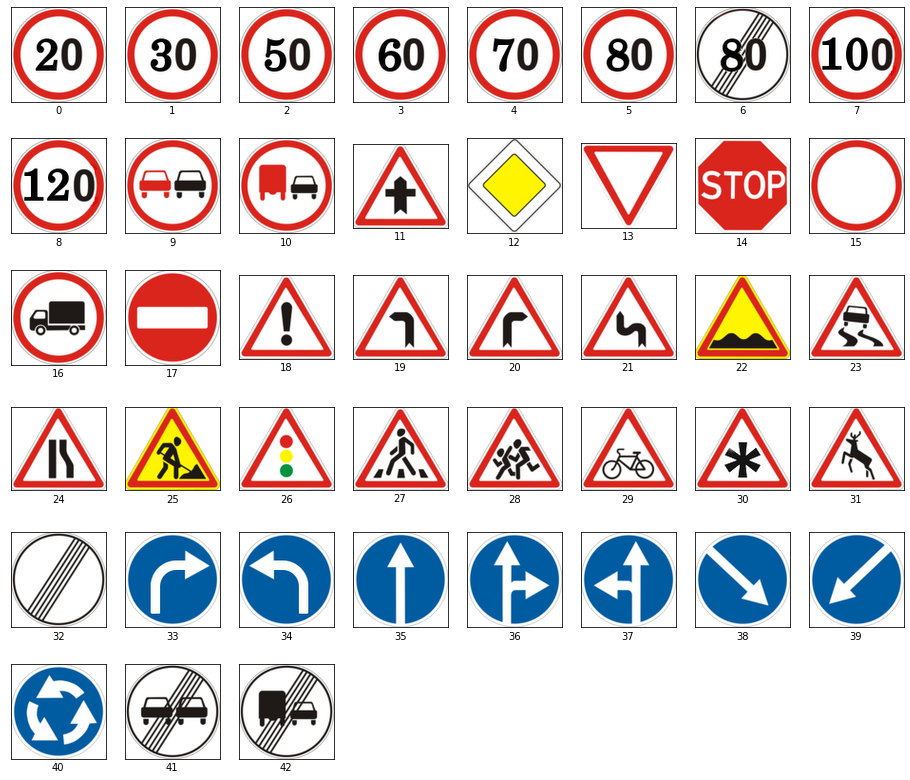

In [6]:
plot_images(x_meta,y_meta, range(43), columns=8, x_size=2, y_size=2, 
                                colorbar=False, y_pred=None, cm='binary')

## 6/ What does it really look like

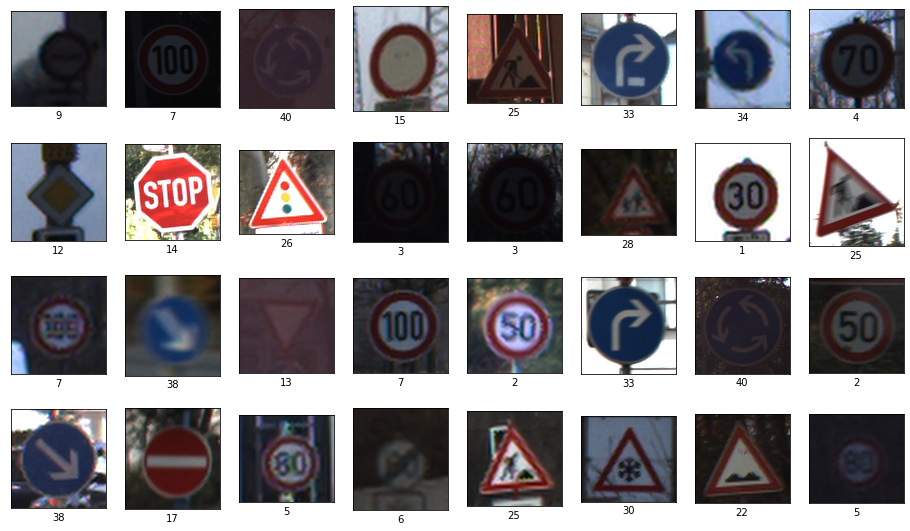

In [7]:
# ---- Get and show few images

samples = [ random.randint(0,len(x_train)-1) for i in range(32)]
plot_images(x_train,y_train, samples, columns=8, x_size=2, y_size=2, colorbar=False, y_pred=None, cm='binary')


## 7/ Data enhancement

Enhancement:     [########################################] 100.0%
Enhancement:     [########################################] 100.0%


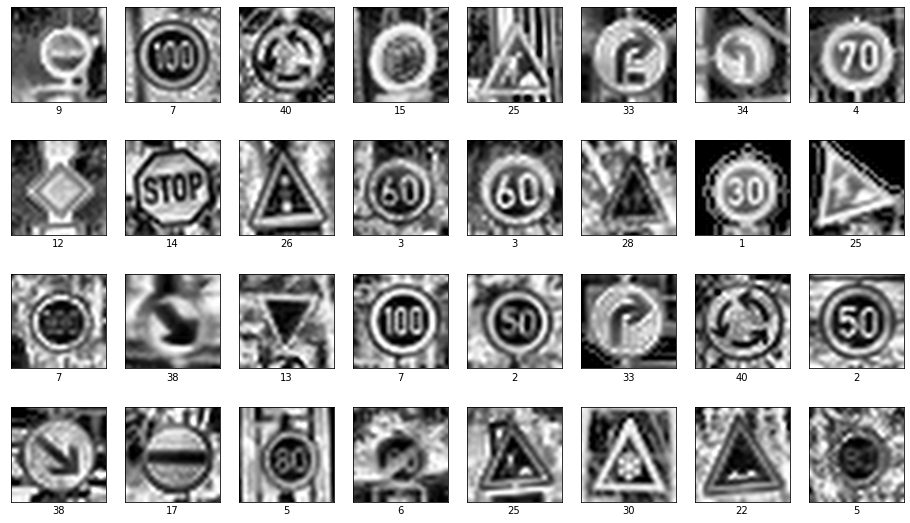

In [8]:
def images_enhancement(images, width=25, height=25, mode='L'):
    '''
    Resize and convert images - doesn't change originals
    args:
        images :         images list
        width,height :   new images size (25,25)
        mode :           new images mode (L)
    return:
        enhanced images : new images as a list of list
    '''
    i=0
    out=[]
    for image in images:
        image=image.resize( (width,height), resample=PIL.Image.LANCZOS)
        image=image.convert(mode)
        npi=np.array(image)
        npi=rank.equalize(npi, disk(10))
#         npi=exposure.equalize_adapthist(npi)
        npi=(npi / 255.).astype(np.float32)
        out.append(npi.tolist())
        i+=1
        update_progress('Enhancement: ',i,len(images))
    return out

# ---- Enhancement
x_train_v2 = images_enhancement(x_train)
x_test_v2  = images_enhancement(x_test)

# ---- Show samples
plot_images(x_train_v2,y_train, samples, columns=8, x_size=2, y_size=2, colorbar=False, y_pred=None, cm='binary')


## 8/ Save it

In [9]:

def save_as_npy(data_list, filename):
    # ---- list -> np
    data = np.array(data_list)
    # ---- save it
    np.save('./data/GTSRB/'+filename, data)
    # ---- done
    size=(data.size*8)/(1024*1024)
    print('Dataset : {:16s} shape : {:18s} size : {:5.1f} Mo  saved !'.format(filename, str(data.shape),size))


save_as_npy(x_train_v2, "x_train.npy")
save_as_npy(y_train,    "y_train.npy")
save_as_npy(x_test_v2,  "x_test.npy")
save_as_npy(y_test,     "y_test.npy")

Dataset : x_train.npy      shape : (39209, 25, 25)    size : 187.0 Mo  saved !
Dataset : y_train.npy      shape : (39209,)           size :   0.3 Mo  saved !
Dataset : x_test.npy       shape : (12630, 25, 25)    size :  60.2 Mo  saved !
Dataset : y_test.npy       shape : (12630,)           size :   0.1 Mo  saved !


## 9/ Reload data

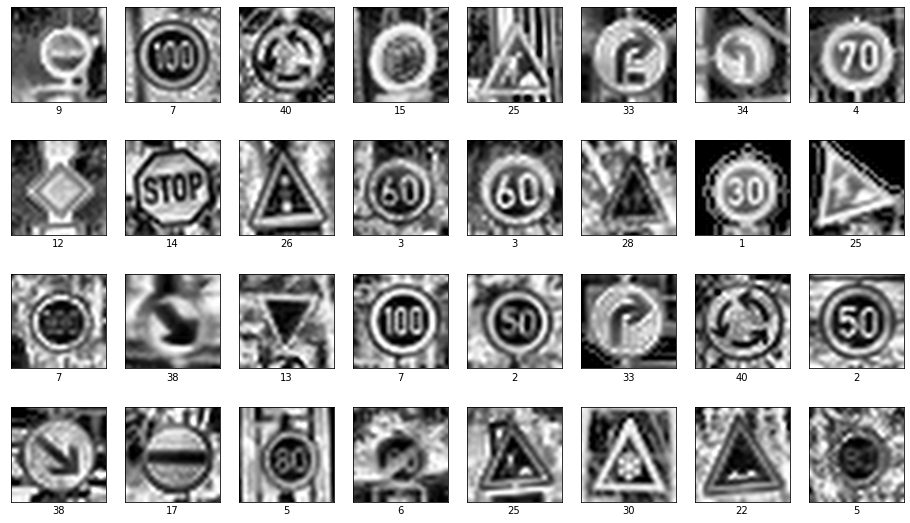

CPU times: user 1.06 s, sys: 250 ms, total: 1.31 s
Wall time: 1.33 s


In [10]:
%%time

x_train = np.load('./data/GTSRB/x_train.npy')
y_train = np.load('./data/GTSRB/y_train.npy')

plot_images(x_train,y_train, samples, columns=8, x_size=2, y_size=2, colorbar=False, y_pred=None, cm='binary')

----
That's all folks !